In [1]:
import os
import pandas as pd
from datetime import datetime
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import contextily as ctx

import rasterio as rio
import rioxarray as rxr

import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

## 1. Import Data

In [2]:
cmap = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#A89F8EFF", "#9B6981FF", "#7887A4FF"] # Arches

In [5]:
# load in field data (this is where the PD LWP data is...)
fielddata = pd.read_csv('../../data/field_data/LWC_LFM_WP_dates20230525.csv')

fielddata['mpa_mean'] = fielddata['mpa_mean'] * -1   # data was collected as positive values

def parse_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d')
    except:
        return None
    
fielddata['date'] = fielddata.apply(lambda row: parse_date(row['date_wp']), axis=1)

In [9]:
# function to filter down to data relevant to the study period (i.e., within 8 days of image dates for predawn)
img_date_list_str = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
img_date_list = [datetime.strptime(datestr, '%Y%m%d') for datestr in img_date_list_str]
img_date_color_list = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#9B6981FF", "#7887A4FF", "#A89F8EFF"] # Arches
color_dict = dict(zip(img_date_list, img_date_color_list))

def check_date_pd(date):
    # check if date is within 8 days of any of the image dates
    for img_date in img_date_list:
        if abs((date - img_date).days) <= 8:
            return True
    return False

pd_lwp = fielddata[['tree', 'time', 'species', 'mpa_mean', 'date']].copy().dropna()
pd_lwp = pd_lwp[pd_lwp['time'] == 'pd']
pd_lwp = pd_lwp[pd_lwp['date'].apply(check_date_pd)]
pd_lwp = pd_lwp.drop_duplicates()

In [ ]:
lai_data = pd.read_csv('../../data/field_data/LAI_final.csv')

,Treestr,Species,springlai,winterlai,earlylai,septlai,difflai,springstdev
0,1338,NaN,1.865864,NaN,NaN,NaN,NaN,NaN
1,1478,B,2.608604,1.163146,NaN,NaN,1.445457,NaN
2,2004,B,4.190653,1.393412,NaN,NaN,2.797241,NaN
3,2005,B,1.743187,0.975296,NaN,NaN,0.767892,NaN
4,2006,B,3.643602,1.487365,NaN,NaN,2.156236,NaN
...,...,...,...,...,...,...,...,...
104,2308/2309,B,2.417898,3.577642,2.066144,2.706831,-1.159743,0.209564
105,2311/2312,B,1.950576,2.736328,NaN,2.420990,-0.785751,0.527881
106,2314/2315,BL,2.029702,1.749276,NaN,1.763825,0.280426,0.077603
107,2347/2348,B,2.307691,1.173289,1.805088,1.617167,1.134402,0.204032


In [18]:
# link up lai values to pd_lwp dataframe...
def get_lai(treenum, date):
    if abs((date - img_date_list[-1]).days) <= 8:
        # get entries from the lai data where treenum is somewhere in the tree column
        lai_entries = lai_data[lai_data['Treestr'].str.contains(str(treenum))]
        return lai_entries['septlai'].mean()
    else:
        lai_entries = lai_data[lai_data['Treestr'].str.contains(str(treenum))]
        return lai_entries['springlai'].mean()
    
pd_lwp['lai'] = pd_lwp.apply(lambda row: get_lai(row['tree'], row['date']), axis=1)

## 2. Plot PD LWP against LAI

                            OLS Regression Results                            
Dep. Variable:               mpa_mean   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     44.25
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           2.96e-10
Time:                        09:36:34   Log-Likelihood:                -110.89
No. Observations:                 193   AIC:                             225.8
Df Residuals:                     191   BIC:                             232.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1848      0.100    -21.745      0.0

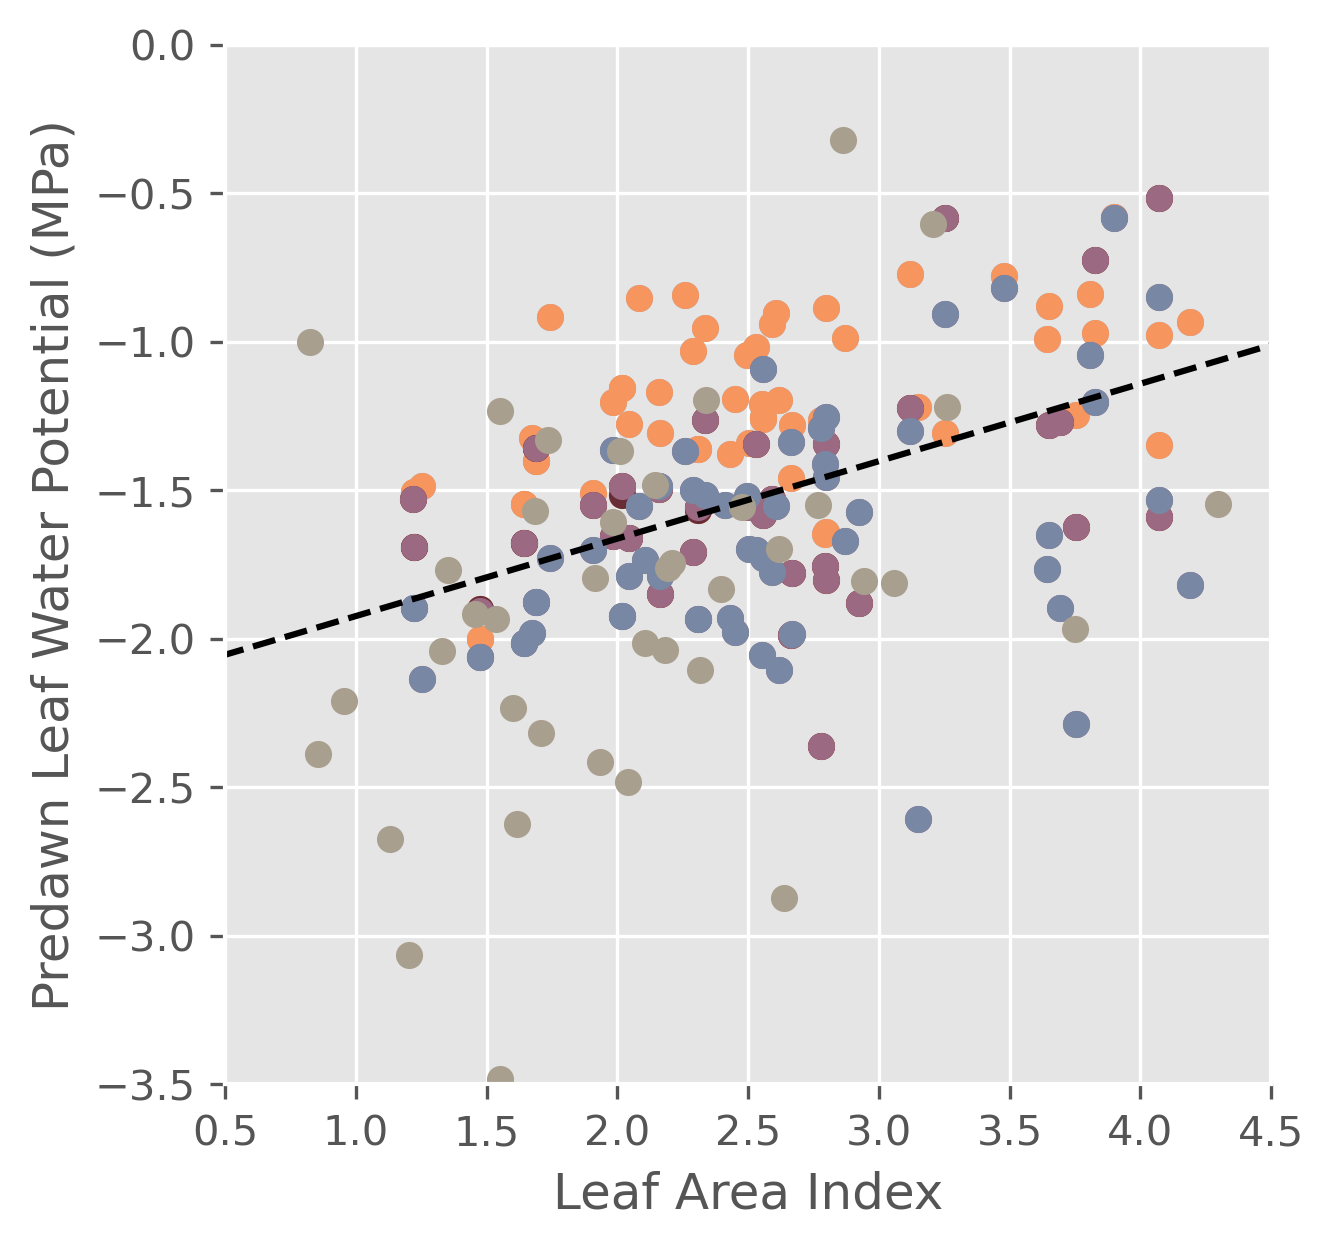

In [46]:
# scatterplot...
fig, ax = plt.subplots(figsize=(4.5, 4.5))

pd_lwp = pd_lwp.dropna()

for date, color in color_dict.items():
    date_pd_lwp = pd_lwp[abs(pd_lwp['date'] - date).dt.days <= 8]
    ax.scatter(date_pd_lwp['lai'], date_pd_lwp['mpa_mean'], color=color, label=date.strftime('%Y-%m-%d'))


# regression
X = pd_lwp['lai']
X = sm.add_constant(X)
y = pd_lwp['mpa_mean']
model = sm.OLS(y, X).fit()
print(model.summary())
abline_values = [model.params['const'] + model.params['lai'] * i for i in np.arange(0, 6, 1)]

ax.plot(np.arange(0, 6, 1), abline_values, color='black', linestyle='--', label='OLS Regression')

ax.set_xlabel('Leaf Area Index')
ax.set_ylabel('Predawn Leaf Water Potential (MPa)')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-3.5, 0)
# ax.legend()
plt.savefig('lai_vs_pd_lwp.png')
plt.show()